In [23]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
random.seed(42)

In [32]:
def split_Xy(data, case):
    """
    Split data into X and y for specific cases
    """
    if case == 1:
        # For stroke dataset
        target = 'stroke'
    else:
        # For heart failure dataset
        target = 'HeartDisease'

    data_y = data[[target]]
    data_y = np.ravel(data_y)
    data_X = data.drop(columns=[target])
    print(data_X.shape, data_y.shape)
    return data_X, data_y


def runLogistic(data_X, data_y, test_X, case):
    if case == 1:
        class_weights = {0: 0.05, 1: 0.95}
    else:
        class_weights = None
    log_reg = LogisticRegression(solver='liblinear', max_iter=300, random_state=42, class_weight=class_weights, )
    log_reg.fit(data_X, data_y)
    return log_reg.predict(test_X)
    

def model_evaluation(true, prediction, label):
    """
    Output evaluation metrics and plot the ROC curve
    """
    accuracy = accuracy_score(true, prediction)
    f1 = f1_score(true, prediction)
    conf_matrix = confusion_matrix(true, prediction)
    precision = precision_score(true, prediction)
    recall = recall_score(true, prediction)
    print(f"Accuracy score: {accuracy}")
    print(f"F1 score: {f1}")
    print(f"Confusion Matrix: \n{conf_matrix}")
    print(f"Precision: {precision} and Recall: {recall}")
    # Calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, _ = roc_curve(true, prediction)

    # Calculate the area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc='lower right')
    plt.show()
    return accuracy, f1, precision, recall, roc_auc

def bias_evaluation(preds, sens, labels, type):
    # stat_parity = P(Pred = 1 ∣ Sen = 1) - P(Pred = 1 ∣ Sen = 0)

    # Calculate the condition probability when accounting for empty array
    if len(preds[sens == 0]):
        preds_1_sens_0 = np.mean(preds[sens == 0])
    else:
        preds_1_sens_0 = 0

    if len(preds[sens == 1]):
        preds_1_sens_1 = np.mean(preds[sens == 1])
    else:
        preds_1_sens_1 = 0

    stat_parity = abs(preds_1_sens_1 - preds_1_sens_0)
    print(f"{type} Statistical Parity: {stat_parity}")

    # Calculate P(Pred = 0 | Sen = 1, Label = 1) minority while account for empty arrays
    if len(preds[(sens == 1) & (labels == 1)]):
        pred_1_sen_1_label_1 = np.mean(preds[(sens == 1) & (labels == 1)])
    else:
        pred_1_sen_1_label_1 = 0

    # Calculate P(Pred = 1 | Sen = 0, Label = 1) while account for empty arrays
    if len(preds[(sens == 0) & (labels == 1)]):
        pred_1_sen_0_label_1 = np.mean(preds[(sens == 0) & (labels == 1)])
    else:
        pred_1_sen_0_label_1 = 0
    equal_op = abs(pred_1_sen_1_label_1 - pred_1_sen_0_label_1)
    print(f"{type} Equal Opportunity: {equal_op}")

    return stat_parity, equal_op

## 1. For original stroke and heart disease data

In [33]:
stroke_base_train = pd.read_csv('data/train_test_data/base_case_stroke_train.csv')
stroke_base_test = pd.read_csv('data/train_test_data/base_case_stroke_test.csv')

stroke_train_X, stroke_train_y = split_Xy(stroke_base_train, 1)
stroke_test_X, stroke_test_y = split_Xy(stroke_base_test, 1)

heart_base_train = pd.read_csv('data/train_test_data/base_case_heart_train.csv')
heart_base_test = pd.read_csv('data/train_test_data/base_case_heart_test.csv')

heart_train_X, heart_train_y = split_Xy(heart_base_train, 2)
heart_test_X, heart_test_y = split_Xy(heart_base_test, 2)

(3576, 11) (3576,)
(1533, 11) (1533,)
(642, 11) (642,)
(276, 11) (276,)


Accuracy score: 0.6164383561643836
F1 score: 0.20108695652173914
Confusion Matrix: 
[[871 573]
 [ 15  74]]
Precision: 0.1143740340030912 and Recall: 0.8314606741573034


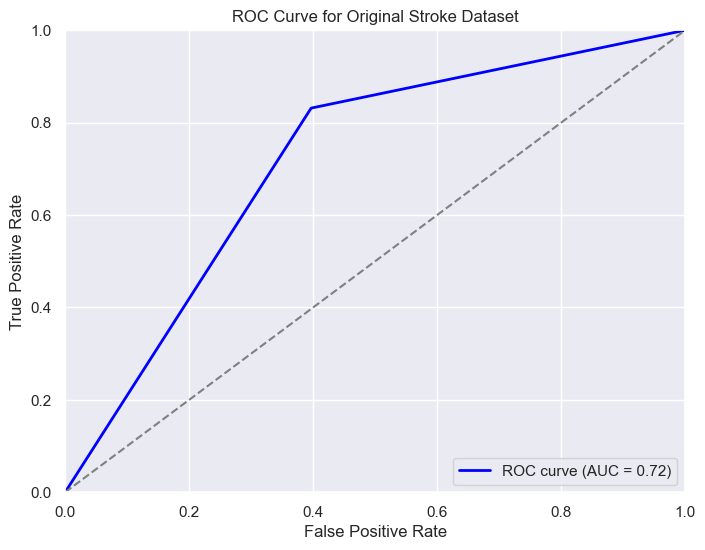

Gender Statistical Parity: 0.03722466960352422
Gender Equal Opportunity: 0.011734693877551106
Age Statistical Parity: 0.8435462842242504
Age Equal Opportunity: 0.8809523809523809


In [34]:
# Run Logistic Regression with class_weights due to inbalanced data
stroke_yhat = runLogistic(stroke_train_X, stroke_train_y, stroke_test_X, 1)
base_stroke_acc, base_stroke_f1, base_stroke_precision, base_stroke_recall, base_stroke_roc = model_evaluation(stroke_test_y, stroke_yhat, 'Original Stroke Dataset')
base_stroke_gen_stat_par, base_stroke_gen_eq_op = bias_evaluation(stroke_yhat, stroke_test_X['gender'], stroke_test_y, 'Gender')
base_stroke_age_stat_par, base_stroke_age_eq_op = bias_evaluation(stroke_yhat, stroke_test_X['age'], stroke_test_y, 'Age')

Accuracy score: 0.855072463768116
F1 score: 0.8757763975155279
Confusion Matrix: 
[[ 95  17]
 [ 23 141]]
Precision: 0.8924050632911392 and Recall: 0.8597560975609756


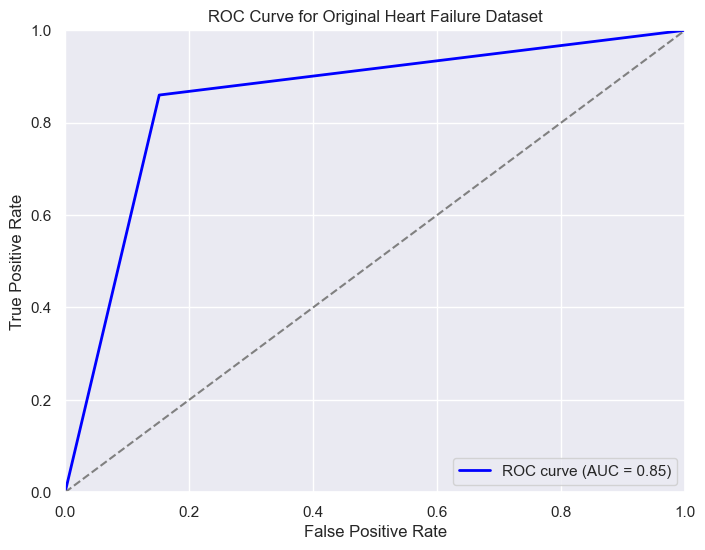

Gender Statistical Parity: 0.3739130434782609
Gender Equal Opportunity: 0.23945335710041593
Age Statistical Parity: 0.15152792413066385
Age Equal Opportunity: 0.1414063702108016


In [35]:
heart_yhat = runLogistic(heart_train_X, heart_train_y, heart_test_X, 0)
base_heart_acc, base_heart_f1, base_heart_precision, base_heart_recall, base_heart_roc = model_evaluation(heart_test_y, heart_yhat, 'Original Heart Failure Dataset')
base_heart_gen_stat_par, base_heart_gen_eq_op = bias_evaluation(heart_yhat, heart_test_X['Sex'], heart_test_y, 'Gender')
base_heart_age_stat_par, base_heart_age_eq_op = bias_evaluation(heart_yhat, heart_test_X['Age'], heart_test_y, 'Age')

## 2. For dataset with protected variables removed

In [36]:
no_prot_stroke_train = pd.read_csv('data/train_test_data/no_prot_class_stroke_train.csv')
no_prot_stroke_test = pd.read_csv('data/train_test_data/no_prot_class_stroke_test.csv')

np_stroke_train_X, np_stroke_train_y = split_Xy(no_prot_stroke_train, 1)
np_stroke_test_X, np_stroke_test_y = split_Xy(no_prot_stroke_test, 1)

no_prot_heart_train = pd.read_csv('data/train_test_data/no_prot_class_heart_train.csv')
no_prot_heart_test = pd.read_csv('data/train_test_data/no_prot_class_heart_test.csv')

np_heart_train_X, np_heart_train_y = split_Xy(no_prot_heart_train, 2)
np_heart_test_X, np_heart_test_y = split_Xy(no_prot_heart_test, 2)

(3576, 9) (3576,)
(1533, 9) (1533,)
(642, 9) (642,)
(276, 9) (276,)


Accuracy score: 0.7429876060013046
F1 score: 0.1959183673469388
Confusion Matrix: 
[[1091  353]
 [  41   48]]
Precision: 0.11970074812967581 and Recall: 0.5393258426966292


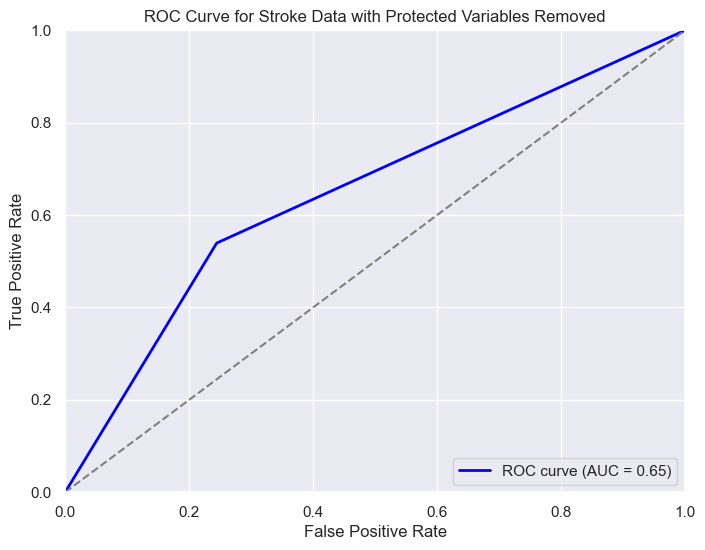

Gender Statistical Parity: 0.025698678414096898
Gender Equal Opportunity: 0.15561224489795916
Age Statistical Parity: 0.3297306313635915
Age Equal Opportunity: 0.3595238095238095


In [37]:
# Run Logistic Regression with class_weights due to inbalanced data
np_stroke_yhat = runLogistic(np_stroke_train_X, np_stroke_train_y, np_stroke_test_X, 1)
np_stroke_acc, np_stroke_f1, np_stroke_precision, np_stroke_recall, np_stroke_roc = model_evaluation(np_stroke_test_y, np_stroke_yhat, 'Stroke Data with Protected Variables Removed')
np_stroke_gen_stat_par, np_stroke_gen_eq_op = bias_evaluation(np_stroke_yhat, stroke_test_X['gender'], np_stroke_test_y, 'Gender')
np_stroke_age_stat_par, np_stroke_age_eq_op = bias_evaluation(np_stroke_yhat, stroke_test_X['age'], np_stroke_test_y, 'Age')

Accuracy score: 0.8478260869565217
F1 score: 0.86875
Confusion Matrix: 
[[ 95  17]
 [ 25 139]]
Precision: 0.8910256410256411 and Recall: 0.8475609756097561


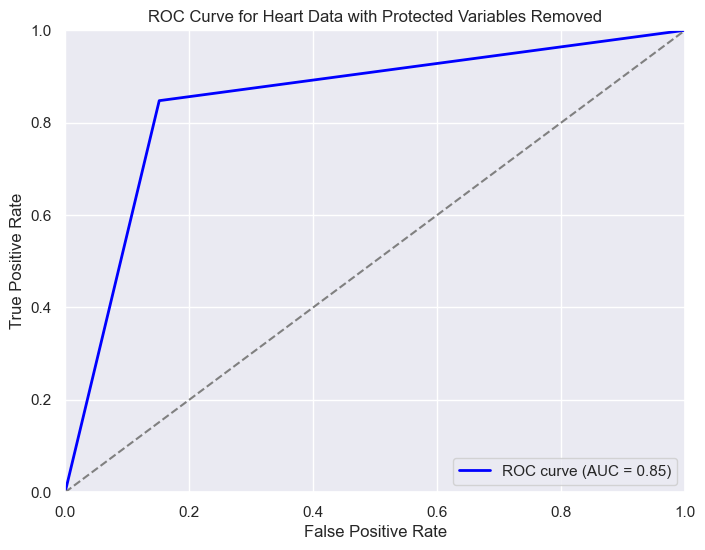

Gender Statistical Parity: 0.3391304347826087
Gender Equal Opportunity: 0.12893642305407005
Age Statistical Parity: 0.1378292939936775
Age Equal Opportunity: 0.12078781350977075


In [38]:
np_heart_yhat = runLogistic(np_heart_train_X, np_heart_train_y, np_heart_test_X, 0)
np_heart_acc, np_heart_f1, np_heart_precision, np_heart_recall, np_heart_roc = model_evaluation(np_heart_test_y, np_heart_yhat, 'Heart Data with Protected Variables Removed')
np_heart_gen_stat_par, np_heart_gen_eq_op = bias_evaluation(np_heart_yhat, heart_test_X['Sex'], np_heart_test_y, 'Gender')
np_heart_age_stat_par, np_heart_age_eq_op = bias_evaluation(np_heart_yhat, heart_test_X['Age'], np_heart_test_y, 'Age')

## 3. For Augmented dataset

In [39]:
aug_stroke_train = pd.read_csv('data/train_test_data/augmented_stroke_train.csv')
aug_stroke_test = pd.read_csv('data/train_test_data/augmented_stroke_test.csv')

aug_stroke_train_X, aug_stroke_train_y = split_Xy(aug_stroke_train, 1)
aug_stroke_test_X, aug_stroke_test_y = split_Xy(aug_stroke_test, 1)

aug_heart_train = pd.read_csv('data/train_test_data/augmented_heart_train.csv')
aug_heart_test = pd.read_csv('data/train_test_data/augmented_heart_test.csv')

aug_heart_train_X, aug_heart_train_y = split_Xy(aug_heart_train, 2)
aug_heart_test_X, aug_heart_test_y = split_Xy(aug_heart_test, 2)

(7152, 11) (7152,)
(1533, 11) (1533,)
(1284, 11) (1284,)
(276, 11) (276,)


Accuracy score: 0.7488584474885844
F1 score: 0.19958419958419954
Confusion Matrix: 
[[1100  344]
 [  41   48]]
Precision: 0.12244897959183673 and Recall: 0.5393258426966292


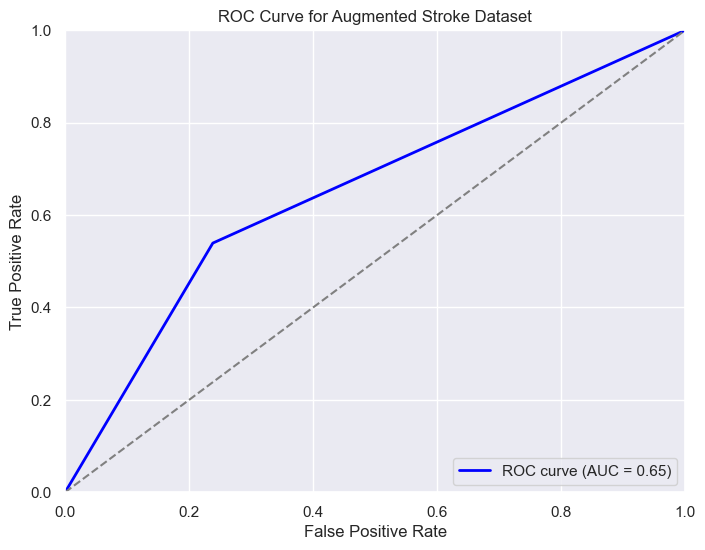

Gender Statistical Parity: 0.024805286343612315
Gender Equal Opportunity: 0.15561224489795916
Age Statistical Parity: 0.32582439466096585
Age Equal Opportunity: 0.3595238095238095


In [40]:
# Run Logistic Regression with class_weights due to inbalanced data
aug_stroke_yhat = runLogistic(aug_stroke_train_X, aug_stroke_train_y, aug_stroke_test_X, 1)
aug_stroke_acc, aug_stroke_f1, aug_stroke_precision, aug_stroke_recall, aug_stroke_roc = model_evaluation(aug_stroke_test_y, aug_stroke_yhat, 'Augmented Stroke Dataset')
aug_stroke_gen_stat_par, aug_stroke_gen_eq_op = bias_evaluation(aug_stroke_yhat, aug_stroke_test_X['gender'], aug_stroke_test_y, 'Gender')
aug_stroke_age_stat_par, aug_stroke_age_eq_op = bias_evaluation(aug_stroke_yhat, aug_stroke_test_X['age'], aug_stroke_test_y, 'Age')

Accuracy score: 0.8478260869565217
F1 score: 0.86875
Confusion Matrix: 
[[ 95  17]
 [ 25 139]]
Precision: 0.8910256410256411 and Recall: 0.8475609756097561


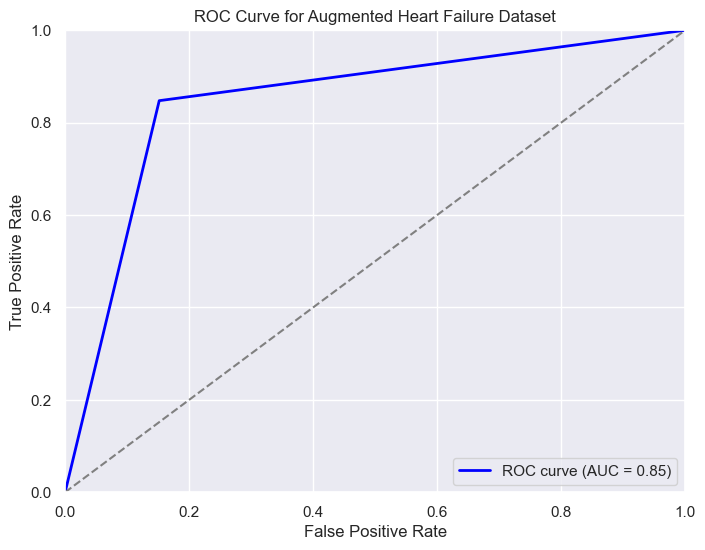

Gender Statistical Parity: 0.3391304347826087
Gender Equal Opportunity: 0.12893642305407005
Age Statistical Parity: 0.1378292939936775
Age Equal Opportunity: 0.12078781350977075


In [41]:
aug_heart_yhat = runLogistic(aug_heart_train_X, aug_heart_train_y, aug_heart_test_X, 0)
aug_heart_acc, aug_heart_f1, aug_heart_precision, aug_heart_recall, aug_heart_roc = model_evaluation(aug_heart_test_y, aug_heart_yhat, 'Augmented Heart Failure Dataset')
aug_heart_gen_stat_par, aug_heart_gen_eq_op = bias_evaluation(aug_heart_yhat, aug_heart_test_X['Sex'], aug_heart_test_y, 'Gender')
aug_heart_age_stat_par, aug_heart_age_eq_op = bias_evaluation(aug_heart_yhat, aug_heart_test_X['Age'], aug_heart_test_y, 'Age')

## 4. For data sampled using SMOTE

In [42]:
smote_stroke_train = pd.read_csv('data/train_test_data/smote_stroke_train.csv')
smote_stroke_test = pd.read_csv('data/train_test_data/smote_stroke_test.csv')

smote_stroke_train_X, smote_stroke_train_y = split_Xy(smote_stroke_train, 1)
smote_stroke_test_X, smote_stroke_test_y = split_Xy(smote_stroke_test, 1)

smote_heart_train = pd.read_csv('data/train_test_data/smote_heart_train.csv')
smote_heart_test = pd.read_csv('data/train_test_data/smote_heart_test.csv')

smote_heart_train_X, smote_heart_train_y = split_Xy(smote_heart_train, 2)
smote_heart_test_X, smote_heart_test_y = split_Xy(smote_heart_test, 2)

(6832, 11) (6832,)
(1533, 11) (1533,)
(688, 11) (688,)
(276, 11) (276,)


Accuracy score: 0.746249184605349
F1 score: 0.19126819126819128
Confusion Matrix: 
[[1098  346]
 [  43   46]]
Precision: 0.11734693877551021 and Recall: 0.5168539325842697


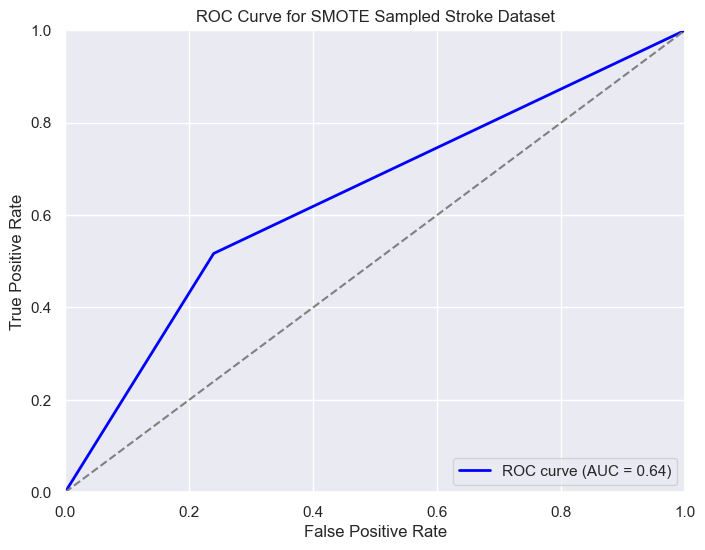

Gender Statistical Parity: 0.16257268722466958
Gender Equal Opportunity: 0.24183673469387756
Age Statistical Parity: 0.45889685833041144
Age Equal Opportunity: 0.5476190476190477


In [43]:
smote_stroke_yhat = runLogistic(smote_stroke_train_X, smote_stroke_train_y, smote_stroke_test_X, 0)
smote_stroke_acc, smote_stroke_f1, smote_stroke_precision, smote_stroke_recall, smote_stroke_roc = model_evaluation(smote_stroke_test_y, smote_stroke_yhat, 'SMOTE Sampled Stroke Dataset')
smote_stroke_gen_stat_par, smote_stroke_gen_eq_op = bias_evaluation(smote_stroke_yhat, smote_stroke_test_X['gender'], smote_stroke_test_y, 'Gender')
smote_stroke_age_stat_par, smote_stroke_age_eq_op = bias_evaluation(smote_stroke_yhat, smote_stroke_test_X['age'], smote_stroke_test_y, 'Age')

Accuracy score: 0.855072463768116
F1 score: 0.875
Confusion Matrix: 
[[ 96  16]
 [ 24 140]]
Precision: 0.8974358974358975 and Recall: 0.8536585365853658


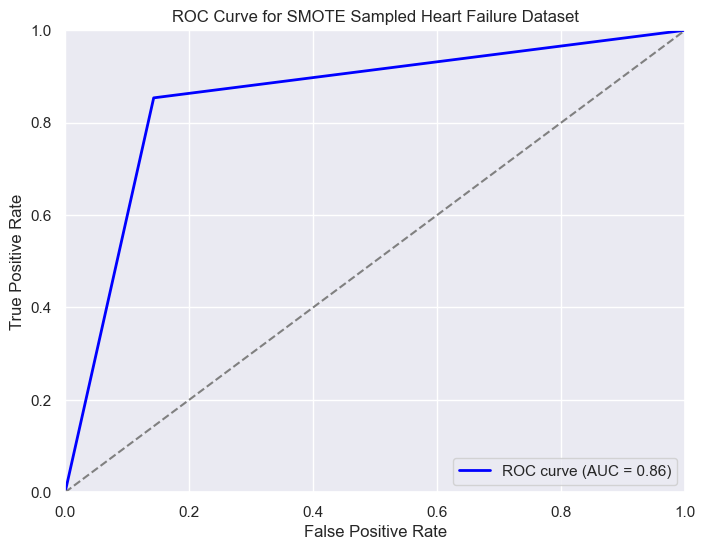

Gender Statistical Parity: 0.391304347826087
Gender Equal Opportunity: 0.23291740938799765
Age Statistical Parity: 0.1378292939936775
Age Equal Opportunity: 0.13109709186028617


In [44]:
smote_heart_yhat = runLogistic(smote_heart_train_X, smote_heart_train_y, smote_heart_test_X, 0)
smote_heart_acc, smote_heart_f1, smote_heart_precision, smote_heart_recall, smote_heart_roc = model_evaluation(smote_heart_test_y, smote_heart_yhat, 'SMOTE Sampled Heart Failure Dataset')
smote_heart_gen_stat_par, smote_heart_gen_eq_op = bias_evaluation(smote_heart_yhat, smote_heart_test_X['Sex'], smote_heart_test_y, 'Gender')
smote_heart_age_stat_par, smote_heart_age_eq_op = bias_evaluation(smote_heart_yhat, smote_heart_test_X['Age'], smote_heart_test_y, 'Age')

## 5. For SMOTE dataset with protected variables removed

In [45]:
smote_np_stroke_train = pd.read_csv('data/train_test_data/smote_no_prot_class_stroke_train.csv')
smote_np_stroke_test = pd.read_csv('data/train_test_data/smote_no_prot_class_stroke_test.csv')

snp_stroke_train_X, snp_stroke_train_y = split_Xy(smote_np_stroke_train, 1)
snp_stroke_test_X, snp_stroke_test_y = split_Xy(smote_np_stroke_test, 1)

smote_np_heart_train = pd.read_csv('data/train_test_data/smote_no_prot_class_heart_train.csv')
smote_np_heart_test = pd.read_csv('data/train_test_data/smote_no_prot_class_heart_test.csv')

snp_heart_train_X, snp_heart_train_y = split_Xy(smote_np_heart_train, 2)
snp_heart_test_X, snp_heart_test_y = split_Xy(smote_np_heart_test, 2)

(6832, 9) (6832,)
(1533, 9) (1533,)
(688, 9) (688,)
(276, 9) (276,)


Accuracy score: 0.6784083496412263
F1 score: 0.13961605584642237
Confusion Matrix: 
[[1000  444]
 [  49   40]]
Precision: 0.08264462809917356 and Recall: 0.449438202247191


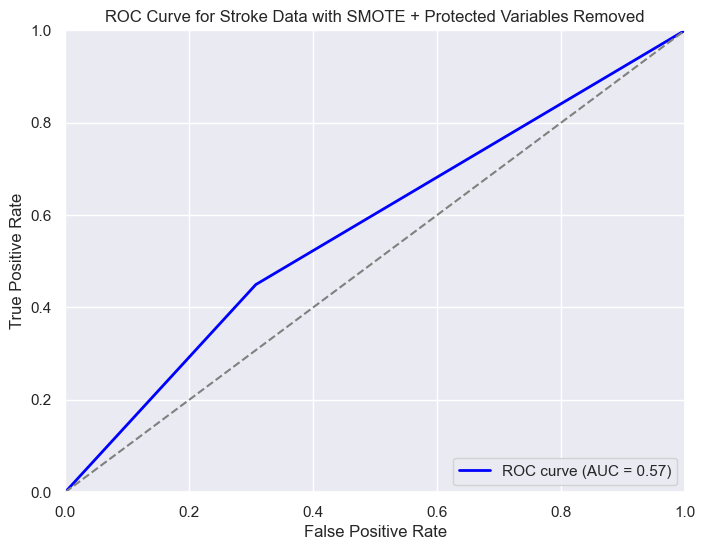

Gender Statistical Parity: 0.04410044052863432
Gender Equal Opportunity: 0.04438775510204085
Age Statistical Parity: 0.09091234030385242
Age Equal Opportunity: 0.05238095238095236


In [46]:
snp_stroke_yhat = runLogistic(snp_stroke_train_X, snp_stroke_train_y, snp_stroke_test_X, 0)
snp_stroke_acc, snp_stroke_f1, snp_stroke_precision, snp_stroke_recall, snp_stroke_roc = model_evaluation(snp_stroke_test_y, snp_stroke_yhat, 'Stroke Data with SMOTE + Protected Variables Removed')
snp_stroke_gen_stat_par, snp_stroke_gen_eq_op = bias_evaluation(snp_stroke_yhat, smote_stroke_test_X['gender'], snp_stroke_test_y, 'Gender')
snp_stroke_age_stat_par, snp_stroke_age_eq_op = bias_evaluation(snp_stroke_yhat, smote_stroke_test_X['age'], snp_stroke_test_y, 'Age')

Accuracy score: 0.8478260869565217
F1 score: 0.86875
Confusion Matrix: 
[[ 95  17]
 [ 25 139]]
Precision: 0.8910256410256411 and Recall: 0.8475609756097561


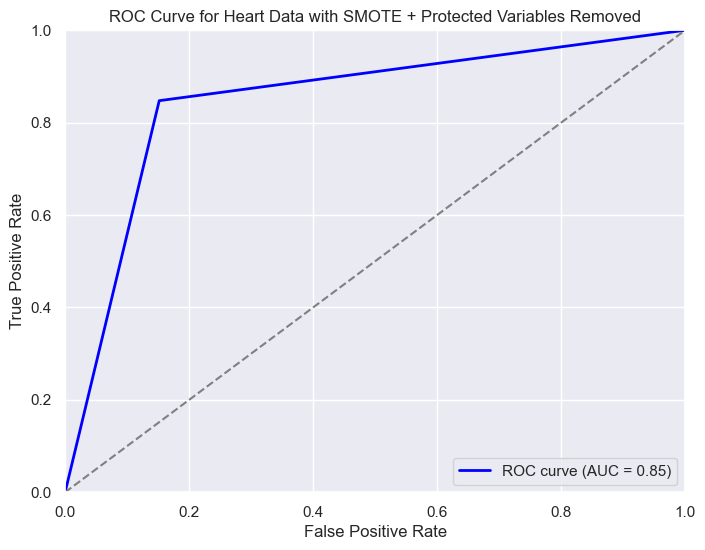

Gender Statistical Parity: 0.3391304347826087
Gender Equal Opportunity: 0.12893642305407005
Age Statistical Parity: 0.1378292939936775
Age Equal Opportunity: 0.12078781350977075


In [47]:
snp_heart_yhat = runLogistic(snp_heart_train_X, snp_heart_train_y, snp_heart_test_X, 0)
snp_heart_acc, snp_heart_f1, snp_heart_precision, snp_heart_recall, snp_heart_roc = model_evaluation(snp_heart_test_y, snp_heart_yhat, 'Heart Data with SMOTE + Protected Variables Removed')
snp_heart_gen_stat_par, snp_heart_gen_eq_op = bias_evaluation(snp_heart_yhat, smote_heart_test_X['Sex'], snp_heart_test_y, 'Gender')
snp_heart_age_stat_par, snp_heart_age_eq_op = bias_evaluation(snp_heart_yhat, smote_heart_test_X['Age'], snp_heart_test_y, 'Age')

## 6. For SMOTE with augmented data

In [48]:
saug_stroke_train = pd.read_csv('data/train_test_data/smote_stroke_augmented_data_train.csv')
saug_stroke_test = pd.read_csv('data/train_test_data/smote_stroke_augmented_data_test.csv')

saug_stroke_train_X, saug_stroke_train_y = split_Xy(saug_stroke_train, 1)
saug_stroke_test_X, saug_stroke_test_y = split_Xy(saug_stroke_test, 1)

saug_heart_train = pd.read_csv('data/train_test_data/smote_heart_augmented_data_train.csv')
saug_heart_test = pd.read_csv('data/train_test_data/smote_heart_augmented_data_test.csv')

saug_heart_train_X, saug_heart_train_y = split_Xy(saug_heart_train, 2)
saug_heart_test_X, saug_heart_test_y = split_Xy(saug_heart_test, 2)

(13664, 11) (13664,)
(1533, 11) (1533,)
(1330, 11) (1330,)
(276, 11) (276,)


Accuracy score: 0.6764514024787998
F1 score: 0.1388888888888889
Confusion Matrix: 
[[997 447]
 [ 49  40]]
Precision: 0.08213552361396304 and Recall: 0.449438202247191


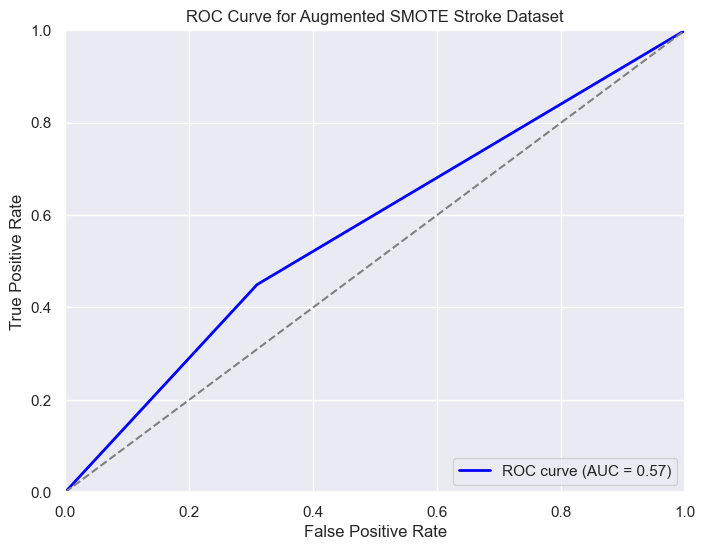

Gender Statistical Parity: 0.0474044052863436
Gender Equal Opportunity: 0.04438775510204085
Age Statistical Parity: 0.09221441920472762
Age Equal Opportunity: 0.05238095238095236


In [49]:
saug_stroke_yhat = runLogistic(saug_stroke_train_X, saug_stroke_train_y, saug_stroke_test_X, 0)
saug_stroke_acc, saug_stroke_f1, saug_stroke_precision, saug_stroke_recall, saug_stroke_roc = model_evaluation(saug_stroke_test_y, saug_stroke_yhat, 'Augmented SMOTE Stroke Dataset')
saug_stroke_gen_stat_par, saug_stroke_gen_eq_op = bias_evaluation(saug_stroke_yhat, saug_stroke_test_X['gender'], saug_stroke_test_y, 'Gender')
saug_stroke_age_stat_par, saug_stroke_age_eq_op = bias_evaluation(saug_stroke_yhat, saug_stroke_test_X['age'], saug_stroke_test_y, 'Age')

Accuracy score: 0.8478260869565217
F1 score: 0.86875
Confusion Matrix: 
[[ 95  17]
 [ 25 139]]
Precision: 0.8910256410256411 and Recall: 0.8475609756097561


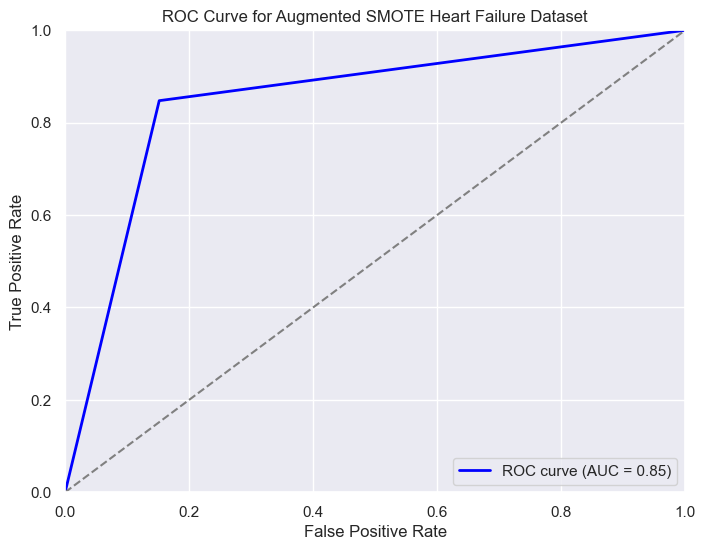

Gender Statistical Parity: 0.3391304347826087
Gender Equal Opportunity: 0.12893642305407005
Age Statistical Parity: 0.1378292939936775
Age Equal Opportunity: 0.12078781350977075


In [50]:
saug_heart_yhat = runLogistic(saug_heart_train_X, saug_heart_train_y, saug_heart_test_X, 0)
saug_heart_acc, saug_heart_f1, saug_heart_precision, saug_heart_recall, saug_heart_roc = model_evaluation(saug_heart_test_y, saug_heart_yhat, 'Augmented SMOTE Heart Failure Dataset')
saug_heart_gen_stat_par, saug_heart_gen_eq_op = bias_evaluation(saug_heart_yhat, saug_heart_test_X['Sex'], saug_heart_test_y, 'Gender')
saug_heart_age_stat_par, saug_heart_age_eq_op = bias_evaluation(saug_heart_yhat, saug_heart_test_X['Age'], saug_heart_test_y, 'Age')

## Summarize evaluation metrics

In [51]:
eval_summary = {'Base_Stroke': [base_stroke_acc, base_stroke_f1, base_stroke_precision, base_stroke_recall, base_stroke_roc, base_stroke_gen_stat_par, base_stroke_gen_eq_op, base_stroke_age_stat_par, base_stroke_age_eq_op],
                'Removed_Prot_Stroke': [np_stroke_acc, np_stroke_f1, np_stroke_precision, np_stroke_recall, np_stroke_roc, np_stroke_gen_stat_par, np_stroke_gen_eq_op, np_stroke_age_stat_par, np_stroke_age_eq_op],
                'Augmented_Stroke': [aug_stroke_acc, aug_stroke_f1, aug_stroke_precision, aug_stroke_recall, aug_stroke_roc, aug_stroke_gen_stat_par, aug_stroke_gen_eq_op, aug_stroke_age_stat_par, aug_stroke_age_eq_op],
                'SMOTE_Stroke': [smote_stroke_acc, smote_stroke_f1, smote_stroke_precision, smote_stroke_recall, smote_stroke_roc, smote_stroke_gen_stat_par, smote_stroke_gen_eq_op, smote_stroke_age_stat_par, smote_stroke_age_eq_op],
                'SMOTE_RmProt_Stroke': [snp_stroke_acc, snp_stroke_f1, snp_stroke_precision, snp_stroke_recall, snp_stroke_roc, snp_stroke_gen_stat_par, snp_stroke_gen_eq_op, snp_stroke_age_stat_par, snp_stroke_age_eq_op],
                'SMOTE_Aug_Stroke': [saug_stroke_acc, saug_stroke_f1, saug_stroke_precision, saug_stroke_recall, saug_stroke_roc, saug_stroke_gen_stat_par, saug_stroke_gen_eq_op, saug_stroke_age_stat_par, saug_stroke_age_eq_op],
                'Base_Heart_Failure': [base_heart_acc, base_heart_f1, base_heart_precision, base_heart_recall, base_heart_roc, base_heart_gen_stat_par, base_heart_gen_eq_op, base_heart_age_stat_par, base_heart_age_eq_op],
                'Removed_Prot_Heart_Failure': [np_heart_acc, np_heart_f1, np_heart_precision, np_heart_recall, np_heart_roc, np_heart_gen_stat_par, np_heart_gen_eq_op, np_heart_age_stat_par, np_heart_age_eq_op],
                'Augmented_Heart_Failure': [aug_heart_acc, aug_heart_f1, aug_heart_precision, aug_heart_recall, aug_heart_roc, aug_heart_gen_stat_par, aug_heart_gen_eq_op, aug_heart_age_stat_par, aug_heart_age_eq_op],
                'SMOTE_Heart_Failure': [smote_heart_acc, smote_heart_f1, smote_heart_precision, smote_heart_recall, smote_heart_roc, smote_heart_gen_stat_par, smote_heart_gen_eq_op, smote_heart_age_stat_par, smote_heart_age_eq_op],
                'SMOTE_RmProt_Heart': [snp_heart_acc, snp_heart_f1, snp_heart_precision, snp_heart_recall, snp_heart_roc, snp_heart_gen_stat_par, snp_heart_gen_eq_op, snp_heart_age_stat_par, snp_heart_age_eq_op],
                'SMOTE_Aug_Heart': [saug_heart_acc, saug_heart_f1, saug_heart_precision, saug_heart_recall, saug_heart_roc, saug_heart_gen_stat_par, saug_heart_gen_eq_op, saug_heart_age_stat_par, saug_heart_age_eq_op]}

summary = pd.DataFrame.from_dict(eval_summary, orient='index', columns=['Accuracy', 'F1_score', 'Precision', 'Recall', 'ROC_score', 'Gender_Stat_Parity', 'Gender_Equal_Opp', 'Age_Stat_Parity', 'Age_Equal_Opp'])
summary

,Accuracy,F1_score,Precision,Recall,ROC_score,Gender_Stat_Parity,Gender_Equal_Opp,Age_Stat_Parity,Age_Equal_Opp
Base_Stroke,0.616438,0.201087,0.114374,0.831461,0.717323,0.037225,0.011735,0.843546,0.880952
Removed_Prot_Stroke,0.742988,0.195918,0.119701,0.539326,0.647433,0.025699,0.155612,0.329731,0.359524
Augmented_Stroke,0.748858,0.199584,0.122449,0.539326,0.650549,0.024805,0.155612,0.325824,0.359524
SMOTE_Stroke,0.746249,0.191268,0.117347,0.516854,0.638621,0.162573,0.241837,0.458897,0.547619
SMOTE_RmProt_Stroke,0.678408,0.139616,0.082645,0.449438,0.570979,0.044100,0.044388,0.090912,0.052381
SMOTE_Aug_Stroke,0.676451,0.138889,0.082136,0.449438,0.569941,0.047404,0.044388,0.092214,0.052381
Base_Heart_Failure,0.855072,0.875776,0.892405,0.859756,0.853985,0.373913,0.239453,0.151528,0.141406
Removed_Prot_Heart_Failure,0.847826,0.868750,0.891026,0.847561,0.847888,0.339130,0.128936,0.137829,0.120788
Augmented_Heart_Failure,0.847826,0.868750,0.891026,0.847561,0.847888,0.339130,0.128936,0.137829,0.120788
SMOTE_Heart_Failure,0.855072,0.875000,0.897436,0.853659,0.855401,0.391304,0.232917,0.137829,0.131097


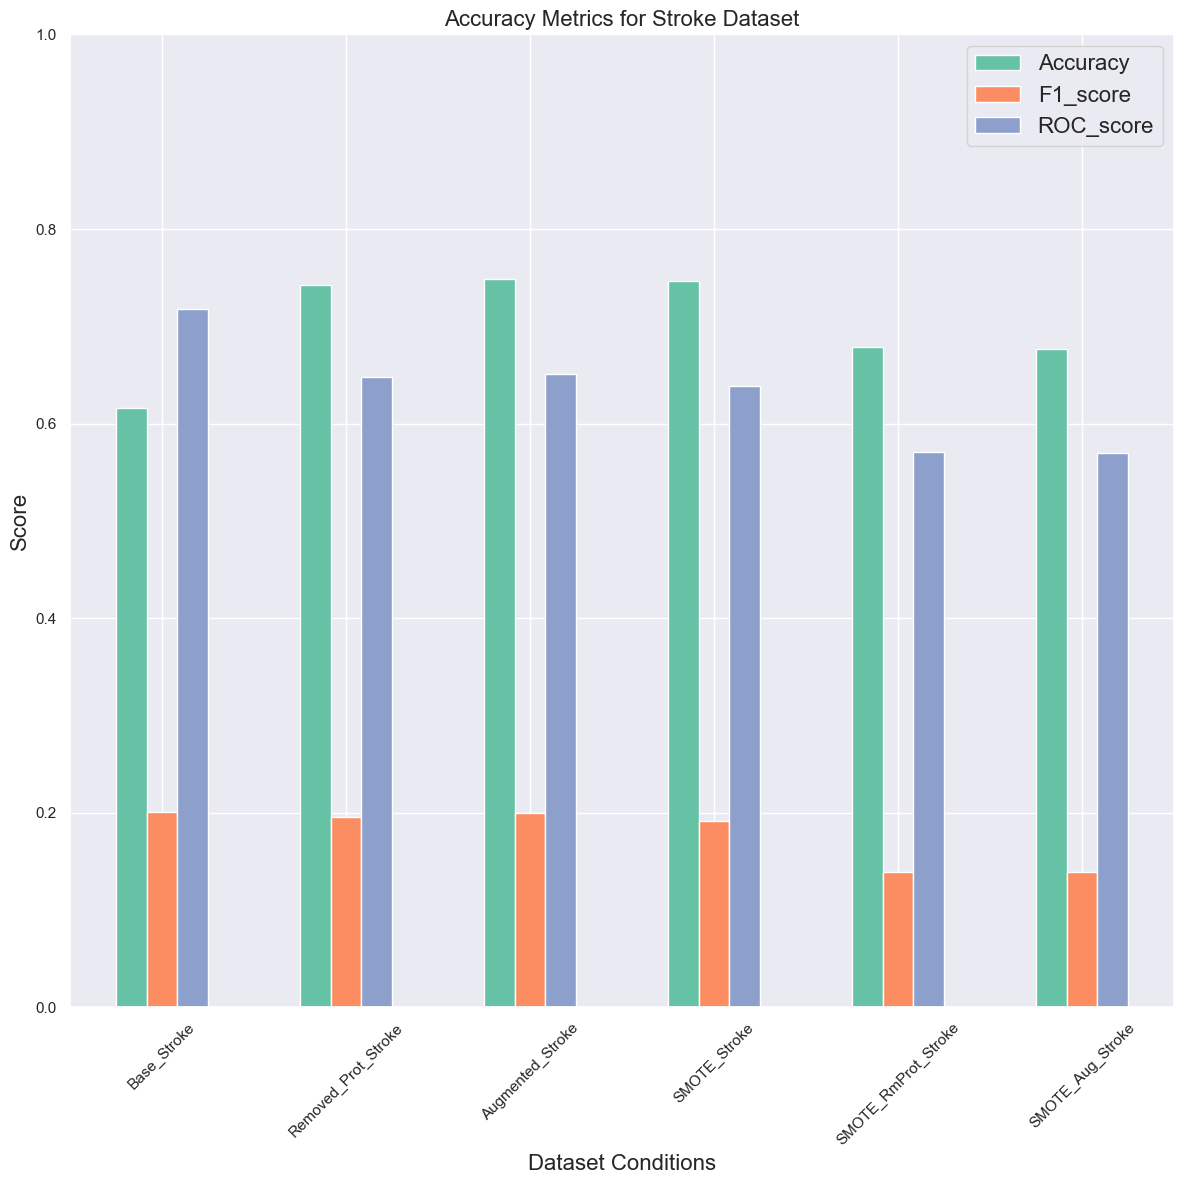

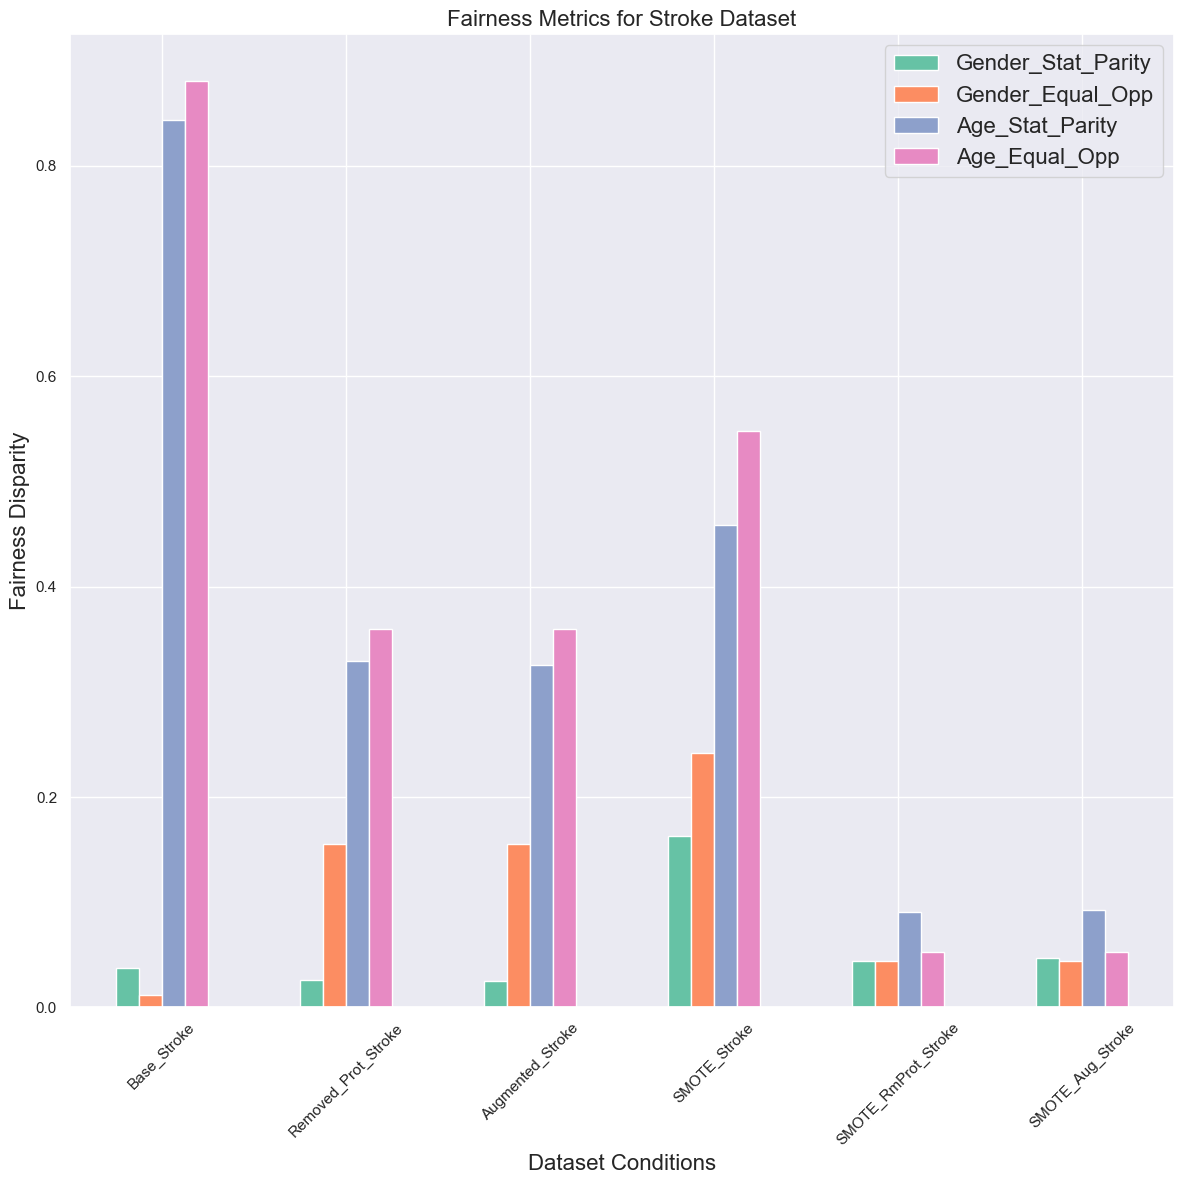

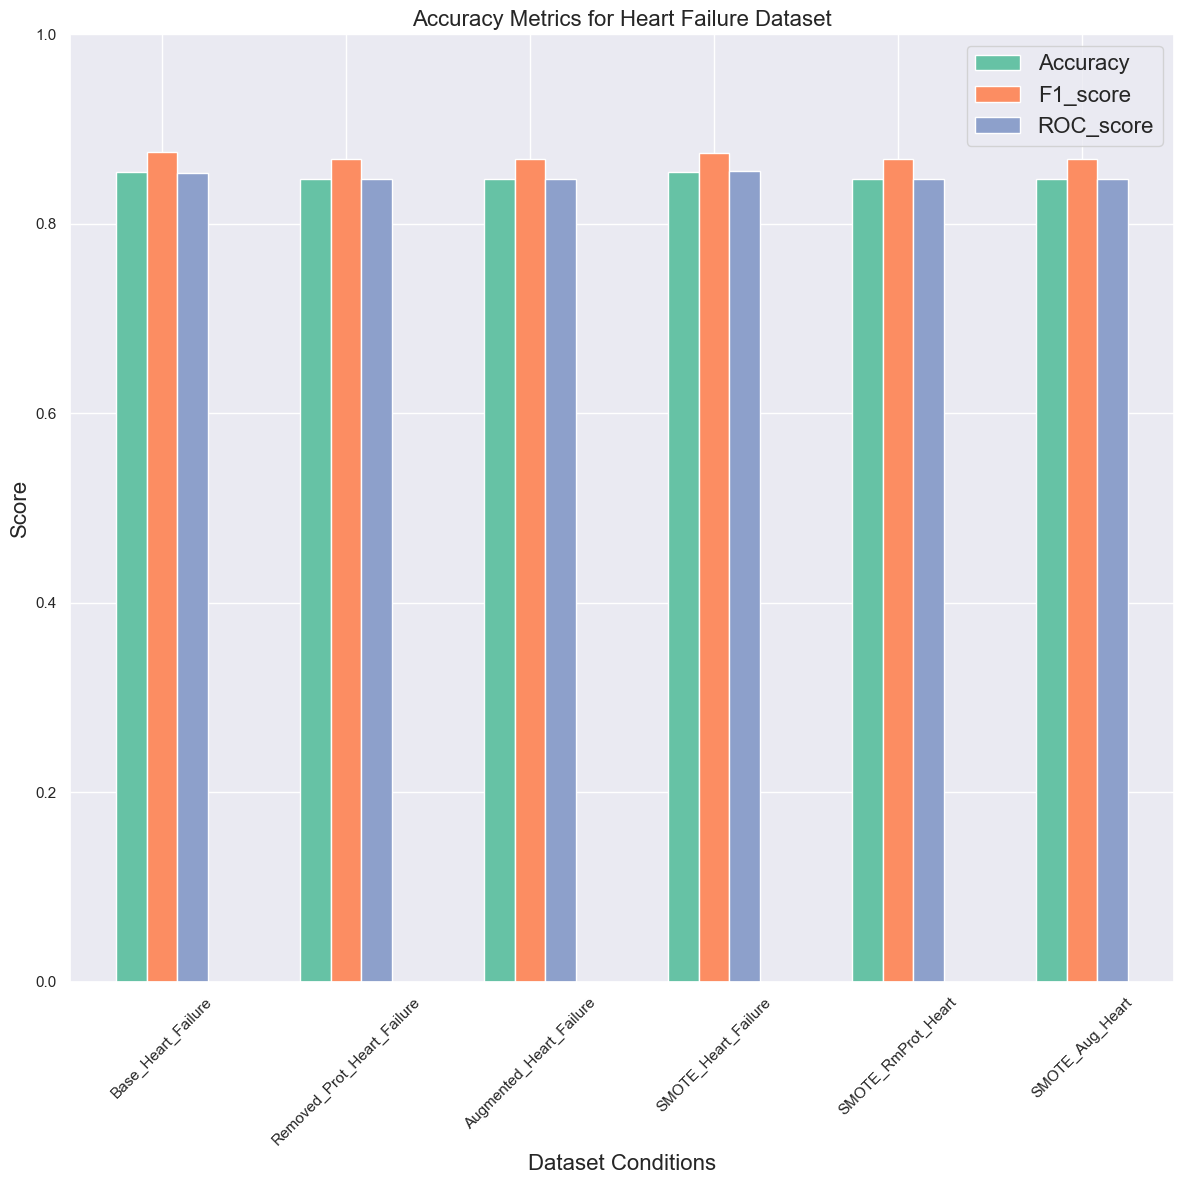

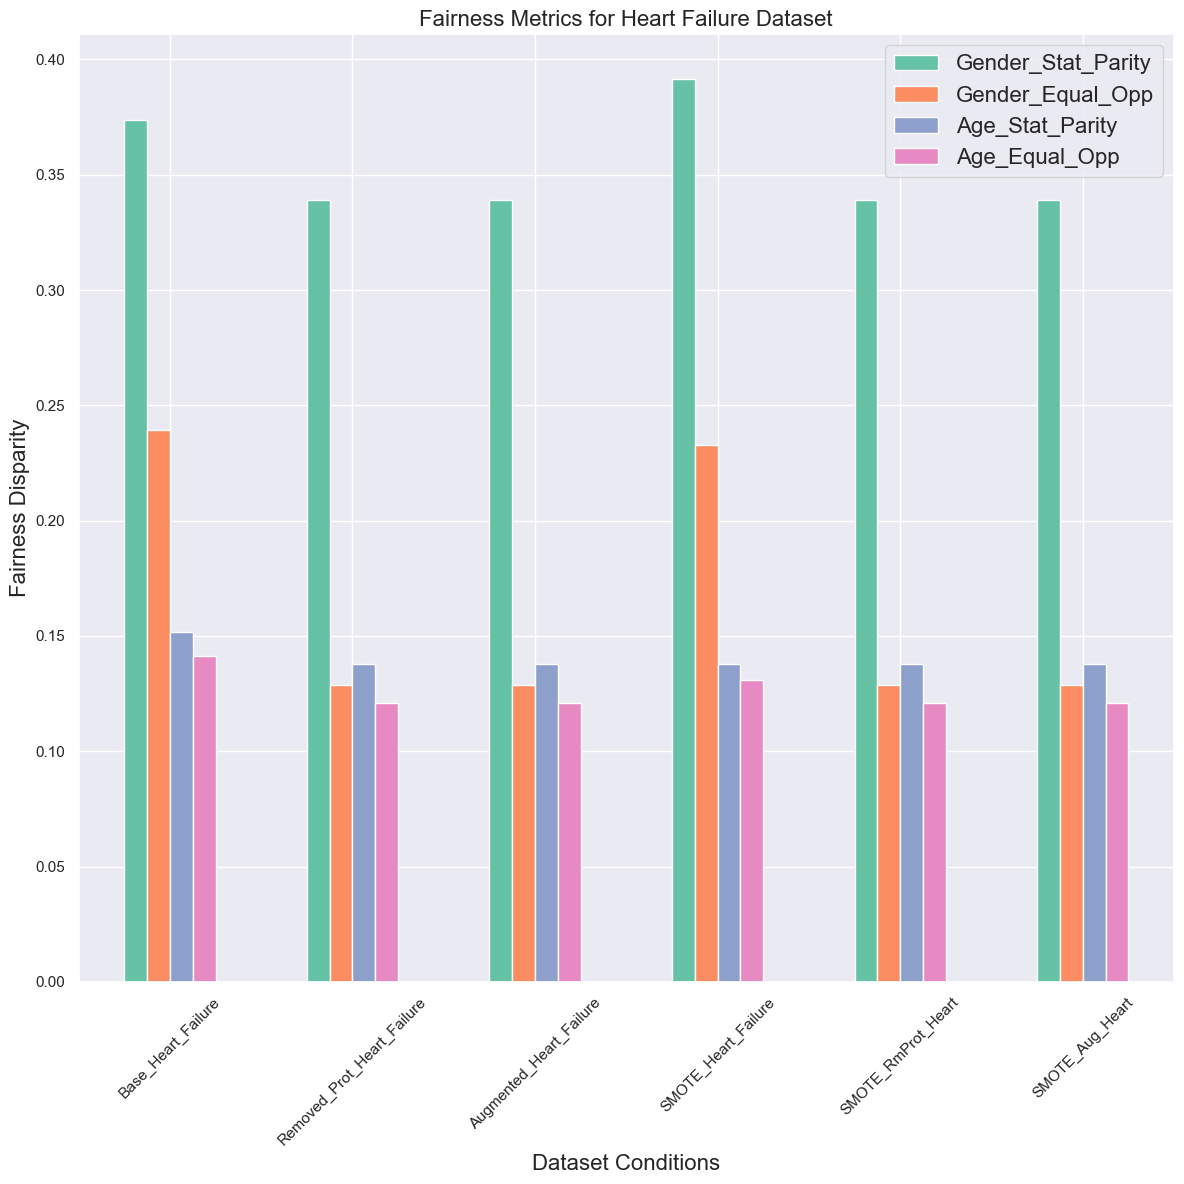

In [74]:
stroke_eval = summary.iloc[:6]
heart_eval = summary.iloc[6:]

sns.set_theme(style="darkgrid")
colors = sns.color_palette('Set2')

# Plotting stroke acc evals
stroke_eval[['Accuracy', 'F1_score', 'ROC_score']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Accuracy Metrics for Stroke Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting stroke fairness evals
stroke_eval[['Gender_Stat_Parity', 'Gender_Equal_Opp', 'Age_Stat_Parity', 'Age_Equal_Opp']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Fairness Metrics for Stroke Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Fairness Disparity', fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting heart failure evals
heart_eval[['Accuracy', 'F1_score', 'ROC_score']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Accuracy Metrics for Heart Failure Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

# Plotting heart failure evals
heart_eval[['Gender_Stat_Parity', 'Gender_Equal_Opp', 'Age_Stat_Parity', 'Age_Equal_Opp']].plot(kind='bar', figsize=(12, 12), color=colors)
plt.title('Fairness Metrics for Heart Failure Dataset', fontsize=16)
plt.xlabel('Dataset Conditions', fontsize=16)
plt.ylabel('Fairness Disparity', fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()